In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib as ilib
import random
from typing import *

import sys
import os
sys.path.append(os.path.abspath("../frbfuncs")) # add frbfuncs folder as a possible candidate to search functions
import cosmology as c
import ktau as kt
import sim

# Information about Samples:

### Luminosity Distribution - Power Law Distribution
For these simulations, we'll use <code> sim.rndm(1e23, 1e26, -1.2, [size], [seed])</code>.  
Note: it will appear pretty close to a linear distribution, since $\gamma + 1$ is close to $0$.

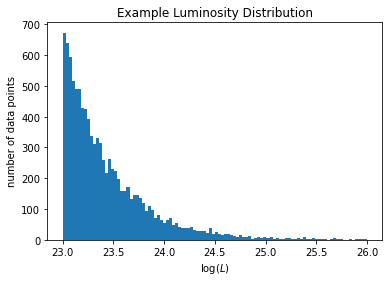

In [2]:
# example luminosity distribution with 1000 points
data = sim.rndm(1e23, 1e26, -2, size=10000, seed=0)
plt.hist(np.log10(data), bins=100)
plt.title('Example Luminosity Distribution')
plt.ylabel('number of data points')
plt.xlabel('$\\log(L)$')
#plt.savefig('../Results/sim graphs 09.14.22/ex_lum_distr.png', dpi=1000)
plt.show()

## Redshift Distribution - Lognormal Distribution
We use <code>rng.lognormal(mean=0.9, sigma=0.6, [size])+0.1</code> to generate a redshift distribution here. The shift by 0.1 is to avoid problems later with the minimum luminosity function close to $z=0$.

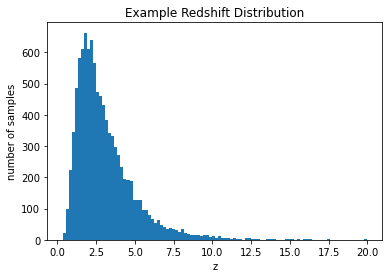

In [3]:
rng = np.random.default_rng(0)
ztest = rng.lognormal(mean=0.9, sigma=0.6, size=10000)+0.1
plt.hist(ztest, bins=100)
plt.title('Example Redshift Distribution')
plt.ylabel('number of samples')
plt.xlabel('z')
#plt.savefig('../Results/sim graphs 09.14.22/ex_z_distr.png', dpi=1000)
plt.show()

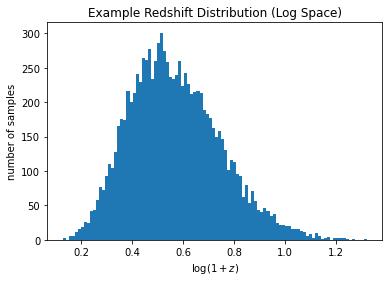

In [4]:
# the same plot, but with log now

plt.hist(np.log10(1+ztest), bins=100)
plt.title('Example Redshift Distribution (Log Space)')
plt.ylabel('number of samples')
plt.xlabel('$\\log(1+z)$')
#plt.savefig('../Results/sim graphs 09.14.22/ex_z_distr_log.png', dpi=1000)
plt.show()

# Kendall-$\tau$ Sampling
functions used:
- sim.frb_sample(zparams, Lparams, size, seed, pdSeries)

## Testing for a Single Sample

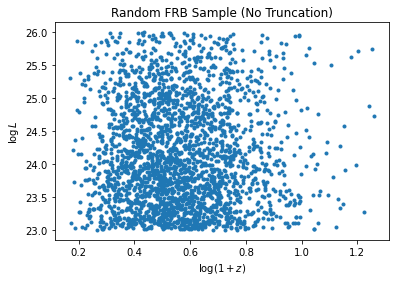

In [175]:
# generate data for one random sample
size = 2500
seed = 8
zsamp, Lsamp = sim.frb_sample(zparams=[0.9, 0.6], Lparams=[1e23, 1e26, -1.2], size=size, seed=seed)
plt.scatter(np.log10(1+zsamp), np.log10(Lsamp), marker='.')
plt.title('Random FRB Sample (No Truncation)')
plt.xlabel('$\\log(1+z)$')
plt.ylabel('$\\log L$')
#plt.savefig("../Results/sim graphs 09.15.22/sample.png", dpi=1000)
plt.show()

In [176]:
#define some minimum luminosity functions

def standard(zs, Ls=None, F=5, alpha=1):
    return c.E_v(Fs=F, z=zs, alpha=alpha)

def allow_all(zs, Ls=None):
    return 1e19*zs + 1e21

minL_func = standard #set the function to be used

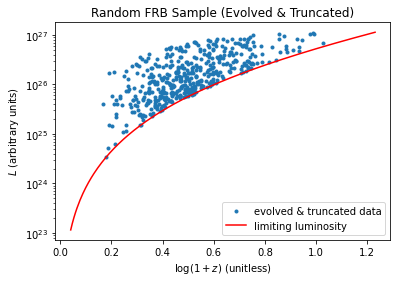

In [177]:
#evolve its luminosity and apply a truncation:
truek = 2
Levo = Lsamp * kt.g_complex(zsamp, truek) #evolve sample
minL = minL_func(zs=zsamp, Ls=Levo)

#truncate
minL_trunc, L_trunc, z_trunc = kt.truncate(minL, Levo, zsamp)

zlim = np.linspace(0.1, 16, 1000)
#plt.scatter(zsamp, Levo, marker='.', alpha=0.3, label='evolved (not truncated) data')
plt.scatter(np.log10(1+z_trunc), L_trunc, marker='.', label='evolved & truncated data')
plt.plot(np.log10(1+zlim), minL_func(zlim), color='red', label='limiting luminosity')
plt.yscale('log')
plt.title('Random FRB Sample (Evolved & Truncated)')
plt.ylabel('$L$ (arbitrary units)')
plt.xlabel('$\\log(1+z)$ (unitless)')
plt.legend()
#plt.savefig("../Results/sim graphs 09.15.22/sample_low_power.png", dpi=1000)
plt.show()

In [178]:
# output size of sample after truncation
print(len(L_trunc))

462


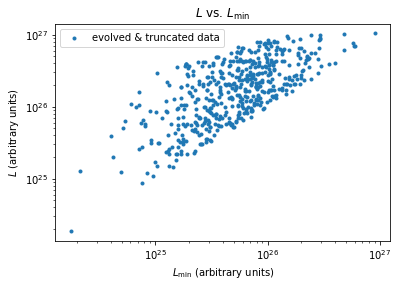

In [160]:
# plot L vs. L_lim
plt.scatter(minL_trunc, L_trunc, marker='.', label='evolved & truncated data')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$L_\\mathrm{min}$ (arbitrary units)')
plt.ylabel('$L$ (arbitrary units)')
plt.title('$L$ vs. $L_\\mathrm{min}$')
plt.legend()
plt.show()

In [161]:
#generate taus for a given sample
num = 20
ks = np.linspace(truek-3, truek+3, num)
taus = np.zeros(num)
for i,k in enumerate(ks):
    taus[i] = kt.ktau_E(L_trunc, minL_trunc, z_trunc, gfunc=kt.g_complex, k=k, params="default")

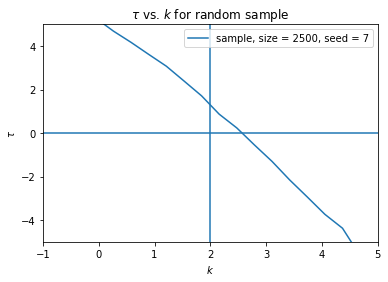

In [166]:
#plot of tau vs k for one random sample

plt.plot(ks, taus, label=f'sample, size = {size}, seed = {seed}')
plt.title('$\\tau$ vs. $k$ for random sample')
plt.ylabel('$\\tau$')
plt.xlabel('$k$')
plt.hlines([0], truek-3, truek+3)
plt.vlines([truek], -5, 5)
plt.ylim([-5, 5])
plt.xlim([truek-3, truek+3])
plt.legend()
#plt.savefig('../Results/sim graphs 09.15.22/tau_k_low_power.png', dpi=1000)
plt.show()

### observations
Shape of $\tau$ vs. $k$ graph:

- always seems to be roughly a straight line
- deviates more when power law distr for $L$ is changed to a more negative power  

Seed:  

- seed seems to randomly affect the y intercept

Size of Sample:

- size affects slope: the larger the size, the steeper the slope (higher absolute magnitude)

Truncation: 

- truncation affects slope: even when compared to untruncated samples with the same size as truncated samples counting *only points that are above the truncation line*, slope is still shallower for truncation

## distribution of $\tau$ at $k=\mathrm{truek}$ across samples

In [179]:
# generate a bunch of random seeds, all connected to one master seed
masterSeed = 0
num_seeds = 100

random.seed(masterSeed)
seeds = []
for i in range(num_seeds):
    seeds.append(random.randint(0, 2e9))

In [180]:
# for each random seed, generate sample, determine tau at k = truek
taus_at_truek = np.zeros(num_seeds)
size = 2500 #original size of each sample
truek = 2 #true value of k
minL_func = standard #set the minimum luminosity function

avg_size_trunc = 0 #track average size after truncation

for i, seed in enumerate(seeds):
    zsamp, Lsamp = sim.frb_sample(zparams=[0.9, 0.6], Lparams=[1e23, 1e26, -1.2], size=size, seed=seed)
    Levo = Lsamp * kt.g_complex(zsamp, truek)
    minL = minL_func(zsamp, Levo)
    minL_trunc, L_trunc, z_trunc = kt.truncate(minL, Levo, zsamp)
    avg_size_trunc += len(minL_trunc)
    taus_at_truek[i] = kt.ktau_E(L_trunc, minL_trunc, z_trunc, gfunc=kt.g_complex, k=truek, params="default")

avg_size_trunc /= num_seeds

In [181]:
# show average size after truncation
print(avg_size_trunc)

498.72


### Variation in $\tau$ at $k=\mathrm{truek}$

mean: -0.09073087255633512
std:  1.0841113768109014


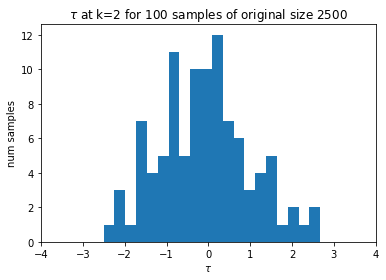

In [182]:
print("mean:", np.mean(taus_at_truek))
print("std: ", np.std(taus_at_truek))
plt.hist(taus_at_truek, bins=20)
plt.title(f'$\\tau$ at k={truek} for {num_seeds} samples of original size {size}')
plt.ylabel('num samples')
plt.xlabel('$\\tau$')
plt.xlim([-4, 4])
if max(taus_at_truek) > 4 or min(taus_at_truek) < -4:
    print("some data is out of the range of this graph.")
plt.show()

### observations
- mean $\approx 0$ and $\sigma \approx 1$ regardless of original sample size or $k$!
- this makes sense, since $\tau$ should be a normalized metric

## next up: Variation in $k$ for $\tau = 0$.
- can be done quicker using a binary search in $k$
- (could be done even quicker using Newton's method, especially since it's roughly a straight line) (TODO)

### binary search for k, single sample

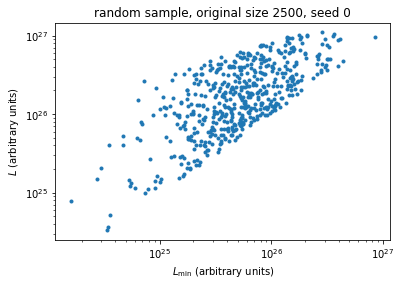

In [183]:
#create one sample
seed = 0
size = 2500 #original size of each sample
truek = 2 #true value of k
minL_func = standard #set the minimum luminosity function

zsamp, Lsamp = sim.frb_sample(zparams=[0.9, 0.6], Lparams=[1e23, 1e26, -1.2], size=size, seed=seed)
Levo = Lsamp * kt.g_complex(zsamp, truek)
minL = minL_func(zsamp, Levo)
minL_trunc, L_trunc, z_trunc = kt.truncate(minL, Levo, zsamp)

#make sure everything looks okay:
plt.scatter(minL_trunc, L_trunc, marker='.')
plt.yscale('log')
plt.xscale('log')
plt.title(f'random sample, original size {size}, seed {seed}')
plt.xlabel('$L_\\mathrm{min}$ (arbitrary units)')
plt.ylabel('$L$ (arbitrary units)')
plt.show()

In [184]:
# binary search function
# note that if k outside of the +-10 range will default to edge of this range

def binary_search_k(minL, L, z, truek, precision=1e-3):
    lo = truek-10
    hi = truek+10
    
    while hi - lo > precision:
        kmid = (hi+lo)/2
        taumid = kt.ktau_E(L, minL, z, gfunc=kt.g_complex, k=kmid, params="default")
        
        if taumid > 0:
            lo = kmid
        elif taumid < 0:
            hi = kmid
        else:
            return kmid
    
    return (hi+lo)/2

#test the function on this sample:
print(binary_search_k(minL_trunc, L_trunc, z_trunc, 3))

2.12139892578125


In [185]:
#generate taus for a given sample
num = 20
ks = np.linspace(truek-3, truek+3, num)
taus = np.zeros(num)
for i,k in enumerate(ks):
    taus[i] = kt.ktau_E(L_trunc, minL_trunc, z_trunc, gfunc=kt.g_complex, k=k, params="default")
    
kfound = binary_search_k(minL_trunc, L_trunc, z_trunc, truek)

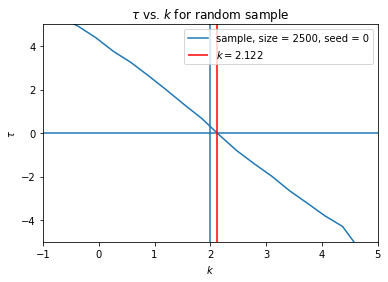

In [186]:
#plot of tau vs k for one random sample. compare with binary search result

plt.plot(ks, taus, label=f'sample, size = {size}, seed = {seed}')
plt.title('$\\tau$ vs. $k$ for random sample')
plt.ylabel('$\\tau$')
plt.xlabel('$k$')
plt.hlines([0], truek-3, truek+3)
plt.vlines([truek], -5, 5)
plt.vlines([kfound], -5, 5, color='red', label=f'$k=${round(kfound, 3)}')
plt.ylim([-5, 5])
plt.xlim([truek-3, truek+3])
plt.legend()
plt.show()

## binary search for many samples

In [187]:
# generate a bunch of random seeds, all connected to one master seed
masterSeed = 0
num_seeds = 100

random.seed(masterSeed)
seeds = []
for i in range(num_seeds):
    seeds.append(random.randint(0, 2e9))

In [199]:
# for each random seed, generate sample, then binary search for k
kfounds = np.zeros(num_seeds)
size = 500 #original size of each sample
truek = 2 #true value of k
minL_func = standard #set the minimum luminosity function

avg_size_trunc = 0 #track average size after truncation

for i, seed in enumerate(seeds):
    #make the sample
    zsamp, Lsamp = sim.frb_sample(zparams=[0.9, 0.6], Lparams=[1e23, 1e26, -1.2], size=size, seed=seed)
    Levo = Lsamp * kt.g_complex(zsamp, truek)
    minL = minL_func(zsamp, Levo)
    minL_trunc, L_trunc, z_trunc = kt.truncate(minL, Levo, zsamp)
    avg_size_trunc += len(minL_trunc)
    
    kfounds[i] = binary_search_k(minL_trunc, L_trunc, z_trunc, truek)

avg_size_trunc /= num_seeds
print("average size after truncation:", avg_size_trunc)

average size after truncation: 98.07


mean: 1.950640869140625
median:  1.74609375
std:  1.194223732890492


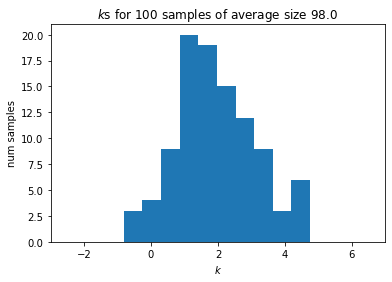

In [201]:
print("mean:", np.mean(kfounds))
print("median: ", np.median(kfounds))
print("std: ", np.std(kfounds))
plt.hist(kfounds, bins=10)
plt.title(f'$k$s for {num_seeds} samples of average size {round(avg_size_trunc,0)}')
plt.ylabel('num samples')
plt.xlabel('$k$')
#maxdif = max(abs())
plt.xlim([truek-5, truek+5])
#plt.savefig('../Results/sim graphs 09.15.22/low_lum_100.png', dpi=1000)
plt.show()

## TODO
- test for different sample sizes, 100, 500, etc.
- use new distribution we discussed in meeting
- email results of simulation in a writeup --> powerpoint
    - distribuiton of L, distribution z, L vs. z, tau vs. k diagrams
- Thursday -- email in advance, see if meetup
- afterwards, look into advancing the stuff on the real data

todo:
- send graphs with higher spectral index
- confirm luminosity and redshift distributions obtained from data are same as expected
- working on true data